## Imports

In [1]:
#Commonted out the below lines as the packages are already installed in the environment

# !pip install timm
# !pip install nibabel
# !pip install nilearn
# !pip install light-the-torch && ltt install torch
#!pip install torchio

import tensorflow as tf
#for neuroimaging data
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
import os
from PIL import Image
from tempfile import TemporaryDirectory
import time
import gc


c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()
gc.collect()

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [3]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {torch.cuda.get_device_name()} for inference' if torch.cuda.is_available() else 'Using CPU for inference')

Using NVIDIA GeForce RTX 3060 Laptop GPU for inference


## Dataset 

In [4]:
root_dir = 'Dataset'

# List all subdirectories in the root directory
subdirectories = [x[0] for x in os.walk(root_dir)]

dataset = []

# Iterate over the subdirectories
for subdir in subdirectories:
    # Check if the subdirectory contains 'anat' in its path
    if 'anat' in subdir:
        # List all files in the subdirectory
        files = os.listdir(subdir)
        # Iterate over the files
        for file in files:
            # Check if the file is a .nii.gz file
            if file.endswith('.nii.gz'):
                file_path = os.path.join(subdir, file)
                # Load the Nifti image using TorchIO
                subject = tio.Subject(
                    mri = tio.ScalarImage(file_path),
                )
                dataset.append(subject)
       

# Print the number of images in the dataset
print('Number of Images in Dataset: ' + str(len(dataset)))

print('First Image Dimensions in Dataset: ')
print(dataset[0].spatial_shape)


Number of Images in Dataset: 245
First Image Dimensions in Dataset: 
(128, 256, 256)


## Import Labels

In [5]:
# check if a file named participants.tsv exists in the each of the subfolder under the root directory
# If it exists, load the file and display the contents
for subdir in subdirectories:
    if os.path.exists(os.path.join(subdir, 'participants.csv')):
        print('Found participants.tsv in ' + subdir)
        df = pd.read_csv(os.path.join(subdir, 'participants.csv'), sep=',', header=0)

for subject in dataset:
    adhd_label = df['dx'].values[0]
    adhd_label = 1 if adhd_label != 'Typically Developing Children' else 0
    subject['adhd'] = adhd_label

Found participants.tsv in Dataset\Peking_1
Found participants.tsv in Dataset\Peking_2
Found participants.tsv in Dataset\Peking_3


## Image Preprocessing

In [6]:
transforms = [
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.CropOrPad((132, 132, 132)),
    tio.RandomAffine(),
    tio.RescaleIntensity((0, 1)),
]
transform = tio.Compose(transforms)
subjects_dataset = tio.SubjectsDataset(dataset, transform=transform)
print(len(subjects_dataset))

245


ADHD Label: 0


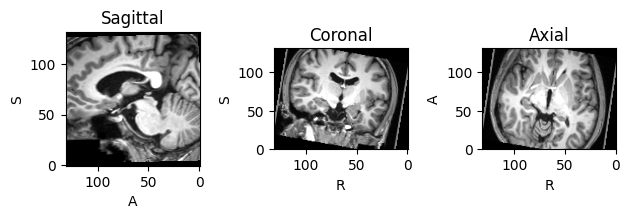

(132, 132, 132)
ADHD Label: 0


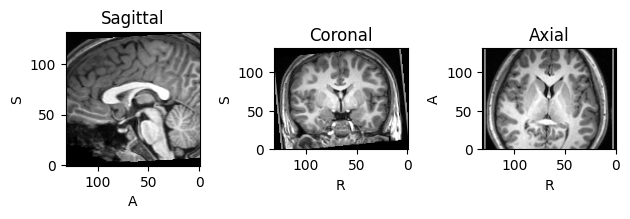

(132, 132, 132)
ADHD Label: 0


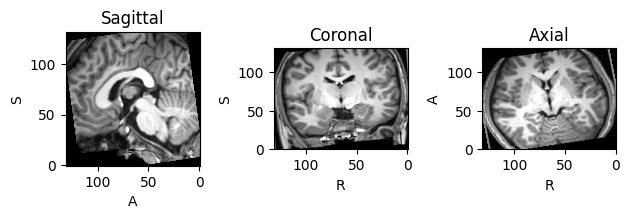

(132, 132, 132)
ADHD Label: 0


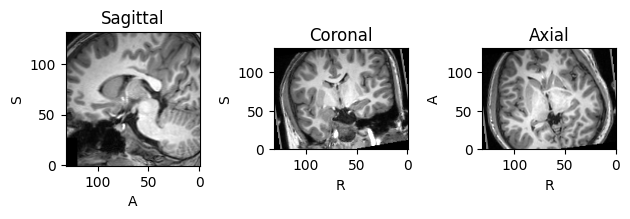

(132, 132, 132)
ADHD Label: 0


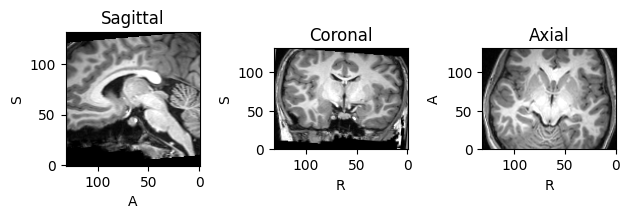

(132, 132, 132)


In [7]:
#Shows the preprocessed images
for i in range(5):
    subject = subjects_dataset[i]
    image = subject['mri']
    print('ADHD Label: ' + str(subject['adhd']))
    image.plot()
    plt.show()
    print(subjects_dataset[i]['mri'].spatial_shape)

## Train/Test Split

In [8]:
# split the torchio dataset into train/test with a 80/20 ratio
n = len(subjects_dataset)
n_train = int(0.8 * n)
n_val = n - n_train
train_dataset, val_dataset = torch.utils.data.random_split(subjects_dataset, [n_train, n_val])


# Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=6, shuffle=True, num_workers=2)

# print the number of batches in the train and validation loaders
print('Number of batches in the train loader: ' + str(len(train_loader)))
print('Number of batches in the validation loader: ' + str(len(val_loader)))


Number of batches in the train loader: 33
Number of batches in the validation loader: 9


## Pre-Trained Model

In [9]:
import torch
import torchvision.models as models

# Load the pre-trained CNN model for neuorimaging data
model = torchvision.models.video.r3d_18(pretrained=True)

# Modify the first layer to accept 1 channel
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

# Modify the fully connected layer
model.fc = nn.Linear(512, 2)


# Print the model architecture
print(model)
model = model.to(device)
print(torch.cuda.get_device_name())


c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
epochs = 5


print('Training Started')

Training Started


## Training

In [11]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
    
# Train the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        print('Batch: ' + str(i))
        inputs = batch['mri']['data'].to(device)
        labels = batch['adhd'].to(device)
        optimizer.zero_grad()       
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch: ' + str(epoch + 1) + ', Loss: ' + str(running_loss / len(train_loader)))
    scheduler.step()


Batch: 0


c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv3d(


Batch: 1


c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.03 GiB. GPU  (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.04 GiB. GPU  (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.05 GiB. GPU  (Triggered internally at ..\ate

Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21


## Evaluation

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        inputs = batch['mri']['data'].to(device)
        labels = batch['adhd'].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %.2f %%' % (100 * correct / total))

# Save the model
torch.save(model.state_dict(), 'model.pth')

print('Model saved as model.pth')


In [ ]:
# Save Checkpoint
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}
torch.save(checkpoint, 'checkpoint.pth')

print('Checkpoint saved as checkpoint.pth')